In [2]:
#!pip install geopandas scikit-image

In [67]:
from skimage import draw
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import cv2
import itertools

%matplotlib inline

In [68]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams["figure.dpi"] = 100

### Get locations of solar arrays according to [Bradbury et al](https://www.nature.com/articles/sdata2016106#data-records)

Uncomment the line below to download all the data (about 50GB) for the first time. Then remember to comment/delete it

In [69]:
#!bash download_data.sh

DATA_FOLDER = '/media/jun/7489891d-6872-431e-88ea-46bb42b4adef/jun/MapData/Data'
TILES_FOLDER = DATA_FOLDER + "/tiles/PV/"

SAT_IMAGE_FOLDER = "/satellites/"
MASK_IMAGE_FOLDER = "/masks/"

TRAIN_IMAGE_FOLDER = TILES_FOLDER + "/train/"
TEST_IMAGE_FOLDER = TILES_FOLDER + "/test/"
TRAIN_TEST_RATIO = 0.2


In [70]:
def read_geojson(geojson_file):
    """When supplied with a malformed geojson, this function tries to return a geodataframe"""#
    
    import fiona
    from shapely.geometry import shape

    collection = list(fiona.open(geojson_file,'r'))
    
    df1 = pd.DataFrame(collection)

    #Check Geometry
    def isvalid(geom):
        try:
            shape(geom)
            return 1
        except:
            return 0
    df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
    df1 = df1[df1['isvalid'] == 1]
    collection = json.loads(df1.to_json(orient='records'))

    #Convert to geodataframe
    return gpd.GeoDataFrame.from_features(collection)

In [71]:
# Load the PV locations
PV_locations = read_geojson(DATA_FOLDER + "/SolarArrayPolygons.geojson")

# Convert strings into lists of lists
PV_locations.polygon_vertices_pixels = PV_locations.polygon_vertices_pixels.apply(lambda row: json.loads(row))

In [73]:
PV_locations.head()

,geometry,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels
0,"POLYGON ((-119.83998 36.92599, -119.84037 36.9...",1,36.926055210000001,-119.8402407,107.6184581,3286.1514870000001,Fresno,136.192872,1513.254134,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.914020,"[[3360.495069, 131.6311637], [3249.19771, 87.9..."
1,"POLYGON ((-119.83998 36.92615, -119.84047 36.9...",2,36.926216680000003,-119.8402414,45.977659000000003,3286.352946,Fresno,155.511714,1727.907934,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.829071,"[[3361.153846, 69.61538462], [3217.615385, 12...."
2,"POLYGON ((-119.83999 36.92621, -119.83999 36.9...",3,36.926277130000003,-119.84017350000001,22.280851290000001,3303.4656570000002,Fresno,111.796591,1242.184349,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.937961,"[[3358.015726, 48.13686322], [3358.05, 48.15],..."
3,"POLYGON ((-119.84271 36.92092, -119.84272 36.9...",4,36.920969360000001,-119.8427983,2048.3625670000001,2547.3661160000001,Fresno,62.004008,688.933420,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.842634,"[[2571.591716, 2068.04931], [2571.021266, 2067..."
4,"POLYGON ((-119.84274 36.92086, -119.84295 36.9...",5,36.920937610000003,-119.8428595,2060.0148899999999,2529.504997,Fresno,95.480150,1060.890554,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.890998,"[[2563.781065, 2091.398422], [2504.416174, 202..."


### Load GeoTiff and plot it in various ways

In [74]:
def plot_geotiff(image_id):
    "Return a matplotlib plot with PVs overlayed"

    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    import matplotlib
    import matplotlib.pyplot as plt


    city = PV_locations[(PV_locations.image_name == image_id)].iloc[0].city
    pv_arrays_in_image = PV_locations[(PV_locations.image_name == image_id)].sort_values("area_meters", ascending=False)

    fname = DATA_FOLDER + '/{0}/{1}.tif'.format(city, image_id)

    img = matplotlib.image.imread(fname)

    aspect_ratio= img.shape[0]/img.shape[1]
    
    fig, ax = plt.subplots(figsize=(10, 10*aspect_ratio), dpi=100)
    
    ax.imshow(img, origin='upper')
    plt.axis('scaled')
    
    patches = []

    for i, row in pv_arrays_in_image.iterrows():
        # convert array in string to list of lists
        polygon = Polygon(row["polygon_vertices_pixels"], True)
        patches.append(polygon)

    p = PatchCollection(patches, color="yellow", linewidth=4, alpha=0.8)

    ax.add_collection(p)

    return plt

In [75]:
def plotly_geotiff(image_id, plot_width=800, plot_height=800):
    """When given an image id, show the image along with an overlay containing all visible PVs using plotly"""
    
    # First get which city the image belongs to
    city = PV_locations[(PV_locations.image_name == image_id)].iloc[0].city
    pv_arrays_in_image = PV_locations[(PV_locations.image_name == image_id)].sort_values("area_meters", ascending=False)

    import plotly.offline as py
    import plotly.graph_objs as go
    from PIL import Image
    
    original_img_width, original_img_height = Image.open(DATA_FOLDER + "/{0}/{1}.tif".format(city, image_id)).size

    py.init_notebook_mode()

    # Original size of image
    img_width, img_height = Image.open(DATA_FOLDER + "/{0}/{1}.jpg".format(city, image_id)).size
    scale_factor = 1

    layout= go.Layout(
                    title="{0} - {1}.tif".format(city, image_id),
                    xaxis = go.layout.XAxis(showticklabels = False,
                                            showgrid=False,
                                            zeroline=False,
                                            range = [0,img_width*scale_factor],
                                           ),
                    yaxis = go.layout.YAxis(showticklabels = False,
                                            showgrid=False,
                                            zeroline=False,
                                            scaleanchor = 'x',
                                            autorange='reversed',
                                            range = [0,img_height*scale_factor]
                                           ),
                    autosize=True,
                    # Size of plotly graph
                    height=plot_height,
                    #width=plot_width,
        margin = {'l': 0, 'r': 0, 't': 30, 'b': 0},
                    images= [dict(
                        source=DATA_FOLDER + "/{0}/{1}.jpg".format(city, image_id),
                        x= 0,
                        sizex=img_width*scale_factor,
                        y=0,#img_height*scale_factor,
                        sizey=img_height*scale_factor,
                        xref="x", yref="y",
                        sizing= "stretch",
                        opacity= 1,
                        layer= "below")]
                     )

    PVs = []
    
    for i, row in pv_arrays_in_image.iterrows():
        polygon_pixels = np.array(row["polygon_vertices_pixels"])
        
        PVs.append(go.Scattergl(
        x=polygon_pixels[:,0] * img_width/original_img_width,
            y=polygon_pixels[:,1] * img_height/original_img_height,
        #y=(original_img_height-polygon_pixels[:,1])*img_height/original_img_height,
            name = "ID: {0} Area: {1:.0f}".format(i, row["area_meters"]),
            text = "Lat: {lat:.3f}° Long: {long:.3f}° Area: {area:.0f}m²".format(lat=float(row["centroid_latitude"]),
                                                                                 long=float(row["centroid_longitude"]),
                                                                                 area=row["area_meters"]),
            mode='lines',
            showlegend = True,
            hoveron = 'fills',
            fill='toself',
            line = dict(width=4, color='blue')))

    py.iplot(dict(data=PVs,layout=layout))

In [76]:
def get_image(image_id, filetype="jpg"):
    """Load an image from disk when given filename and, optionally, filetype"""
    
    from PIL import Image
    # First get which city the image belongs to
    city = PV_locations[(PV_locations.image_name == image_id)].iloc[0].city

    image = np.array(Image.open(DATA_FOLDER + "/{0}/{1}.{2}".format(city, image_id, filetype)))
    if image.shape[2] == 4:
        print("{0} {1}.{2}: This image has a 4th dimension!".format(city, image_id, filetype))
        return image[:,:,:3]
    return image

Get a random image from the dataset and plot it with the PV locations marked on

<module 'matplotlib.pyplot' from '/home/jun/anaconda3/envs/solar/lib/python3.6/site-packages/matplotlib/pyplot.py'>

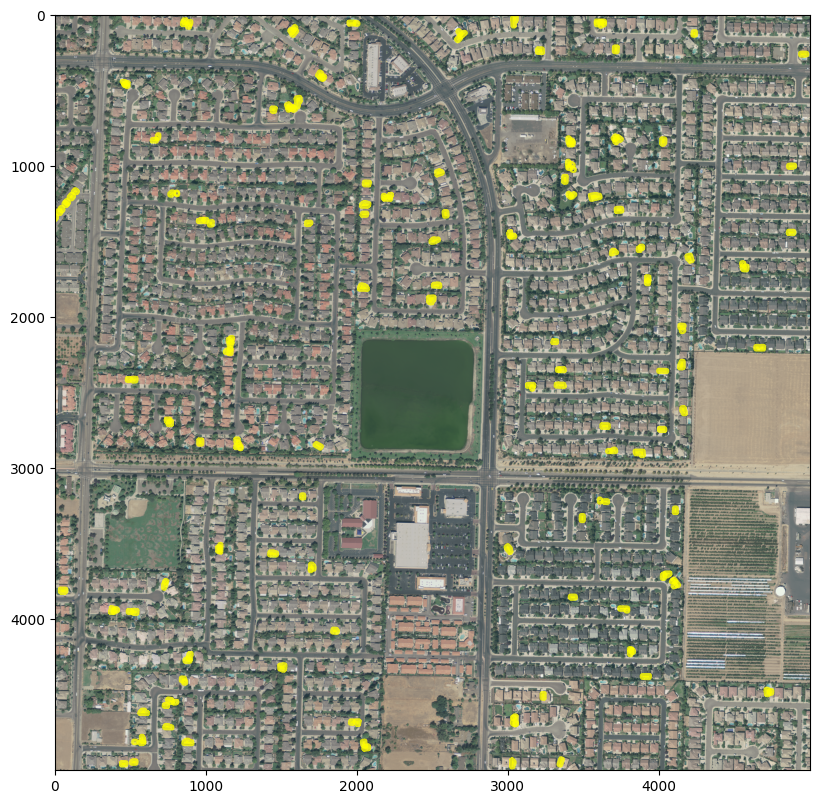

In [77]:
# Here's a random satellite image from the dataset
random_image = PV_locations.sample(n=1).iloc[0]["image_name"]
# Plot it with MPL
plot_geotiff(random_image)

Plot it with Plotly to get an interactive version

In [11]:
#plotly_geotiff(random_image, plot_height=800)

### Let's get tiles of all satellite images along with their paired ground truth masks

In [78]:
def scale_image_with_padding(image, tile_size):
    """When given an image and tile size, this function enlargens the image by padding it to fit the tiles exactly"""
    
    tile_size = np.array(tile_size)
    # Calculate new image size
    new_size = (np.ceil(image.shape[:2]/np.array(tile_size))*np.array(tile_size)).astype(int)
    
    if len(image.shape) == 3:
        return np.pad(image, [(0,new_size[0] - image.shape[0]),
                          (0,new_size[1] - image.shape[1]),
                         (0,0)], "constant", constant_values=0)
    else:
        return np.pad(image, [(0,new_size[0] - image.shape[0]),
                          (0,new_size[1] - image.shape[1])], "constant", constant_values=0)

In [79]:
def get_tile_images(image, width=8, height=8):
    """Credits: https://stackoverflow.com/a/48483743/600413
    This generator returns tiles from image of size width x height
    """
    # First pad the image if tiles don't fit
    image = scale_image_with_padding(image, (width, height))
    
    if len(image.shape) == 3:
        _nrows, _ncols, depth = image.shape
    else:
        # Masks don't have 3rd dimension
        _nrows, _ncols = image.shape
        depth = 1
    _size = image.size
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)
    if _m != 0 or _n != 0:
        return None

    tiles = np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width, depth) if depth == 3 else (nrows, ncols, height, width),
        strides=(height * _strides[0], width * _strides[1], *_strides),
        writeable=False
    )

    for i in range(nrows):
        for j in range(ncols):
            yield tiles[i, j]

In [80]:
def get_mask(image, image_name):
    """Return a mask image containing all PV locations"""
    
    # Create an empty mask to hold PV locations
    mask = np.zeros((image.shape[1], image.shape[0])).astype(np.int32)

    # Loop over all PV polygons in this image
    for polygon in PV_locations[PV_locations.image_name == image_name]["polygon_vertices_pixels"].tolist():
        # Feed polygon into OpenCV to draw onto mask
        polygon_coords = np.array(polygon).astype(np.int32).T
        rr, cc = draw.polygon(np.clip(polygon_coords[0], 0, mask.shape[0]), np.clip(polygon_coords[1], 0, mask.shape[1]))
        try:
            mask[rr, cc] = 1
        except:
            return image_name
    return mask.T

In [81]:
def tiles_for_image(image_name, tile_size):
    """Returns a dictionary for each tile in
    image containing the satellite tile, ground truth mask and associated info"""
    
    pic = get_image(image_name, "tif")
    mask = get_mask(pic, image_name)
    
    sat_tiles = get_tile_images(pic, *tile_size)
    mask_tiles = get_tile_images(mask, *tile_size)
    
    return ({"satellite_image": tile[0],
            "ground_truth": tile[1],
            "image_name": image_name} for tile in zip(sat_tiles, mask_tiles))

### Export satellite and mask tiles as pngs, storing only the ones with PV pixels in them

In [82]:
# Here's a list of all image names
all_images = PV_locations.image_name.unique()
# Get tiles of all images
# The chain function merges all the iterables together into one stream
all_tiles = itertools.chain.from_iterable((tiles_for_image(image, TILE_SIZE) for image in all_images))

In [ ]:
## Uncomment below to just view tiles

#tile = next(all_tiles)
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
#plt.suptitle(tile["image_name"])
#ax1.imshow(tile["satellite_image"])
#ax2.imshow(tile["ground_truth"], vmin=0, vmax=1)
#plt.axis("scaled")
#plt.show()

In [83]:
import random

def generate_random_uuid():
    
    uid_chars = ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
             'v', 'w', 'x', 'y', 'z','1','2','3','4','5','6','7','8','9','0')
    uid_length=8
    
    c=''
    for i in range(0,uid_length):
        c+=random.choice(uid_chars)
    return c

In [84]:
import os
from PIL import Image
import shutil


try:
    pass#shutil.rmtree(TILES_FOLDER + SAT_IMAGE_FOLDER, ignore_errors=True)
    #shutil.rmtree(TILES_FOLDER + MASK_IMAGE_FOLDER, ignore_errors=True)
except FileNotFoundError:
    pass

os.makedirs(TILES_FOLDER + SAT_IMAGE_FOLDER, exist_ok=True)
os.makedirs(TILES_FOLDER + MASK_IMAGE_FOLDER, exist_ok=True)

# Iterate over all tiles and save em
for tile in all_tiles:#itertools.islice(all_tiles, 1000):
    # How many PV pixels are there in the tile?
    classes, counts = np.unique(tile["ground_truth"], return_counts=True)
    if len(classes) == 2:
        num_pv_pixels = counts[1]
    else:
        num_pv_pixels = 0
    
    ## Only save tiles which have at least one PV pixel because otherwise the dataset will be too imbalanced
    if num_pv_pixels > 0:
        # Generate random id
        uuid = generate_random_uuid()
        tile_image_name = "{0}-{1}.png".format(tile["image_name"], uuid)

        # Save satellite and mask images
        Image.fromarray(tile["satellite_image"]).save(TILES_FOLDER + SAT_IMAGE_FOLDER + "/" + tile_image_name)
        mask_im = tile["ground_truth"].astype("uint8")
        mask_im[mask_im == 1] = 255
        Image.fromarray(mask_im).save(TILES_FOLDER + MASK_IMAGE_FOLDER + "/" + tile_image_name)


Fresno 11ska385725.tif: This image has a 4th dimension!


#### Separate tiles into training and testing sets

In [85]:
import glob
import shutil
from sklearn.model_selection import train_test_split


image_filenames = [file.replace(TILES_FOLDER + SAT_IMAGE_FOLDER, "") for file in glob.glob(TILES_FOLDER + SAT_IMAGE_FOLDER + "/*.png")]
# -

train_set, test_set = train_test_split(image_filenames, test_size=config.TRAIN_TEST_RATIO, random_state=42)
[os.makedirs(folder, exist_ok=True) for folder in [TRAIN_IMAGE_FOLDER + SAT_IMAGE_FOLDER + "/0/", TEST_IMAGE_FOLDER + SAT_IMAGE_FOLDER + "/0/",
                                                 TRAIN_IMAGE_FOLDER + MASK_IMAGE_FOLDER  + "/0/", TEST_IMAGE_FOLDER + MASK_IMAGE_FOLDER + "/0/"]]

# #### Move images into relevant directories

# + {}
for image_name in train_set:
    shutil.move(TILES_FOLDER + SAT_IMAGE_FOLDER + image_name, TRAIN_IMAGE_FOLDER + SAT_IMAGE_FOLDER + "/0/" + image_name)
    shutil.move(TILES_FOLDER + MASK_IMAGE_FOLDER + image_name, TRAIN_IMAGE_FOLDER + MASK_IMAGE_FOLDER + "/0/" + image_name)
    
for image_name in test_set:
    shutil.move(TILES_FOLDER + SAT_IMAGE_FOLDER + image_name, TEST_IMAGE_FOLDER + SAT_IMAGE_FOLDER + "/0/" + image_name)
    shutil.move(TILES_FOLDER + MASK_IMAGE_FOLDER + image_name, TEST_IMAGE_FOLDER + MASK_IMAGE_FOLDER +  "/0/" + image_name)


# Prescreening process below
This is not in use at the moment

### Calculate multivariate gaussian distribution for RGB colour distribution of all PV pixels in dataset

In [86]:
from scipy.stats import multivariate_normal
import pickle

try:
    PV_multivariate_RGB, PV_mean, PV_covariance = pickle.load(open(DATA_FOLDER + "/multivariate.p", "rb"))
except FileNotFoundError:
    all_pv_pixels = []

    # Loop over all images
    for i, satellite_image in enumerate(PV_locations.image_name.unique()):
        pic = get_image(satellite_image, "tif")

        mask = get_mask(pic, satellite_image)

        # Convert to boolean array
        mask = mask.astype(bool)

        all_pv_pixels.append(pic[mask])

        if i%50 == 0:
            print("{0} images completed".format(i))

    all_pv_pixels = np.concatenate(all_pv_pixels)

    # Calculate the mean colour of all labelled PVs
    PV_mean = np.apply_over_axes(np.mean, all_pv_pixels, (0))
    # Calculate covariance of labelled PVs
    PV_covariance = np.cov(all_pv_pixels, rowvar=0)
    # Now fit a multivariate normal distribution to this
    PV_multivariate_RGB = multivariate_normal(PV_mean[0], PV_covariance)

    import pickle
    # Save model to file
    pickle.dump((PV_multivariate_RGB, PV_mean, PV_covariance), open(DATA_FOLDER + "/multivariate.p", "wb"))

In [87]:
PV_multivariate_RGB.logpdf(PV_mean)

-10.876538632179635

### Use MSER to prescreen image tiles

In [88]:
def mser(image):
    "Get MSER regions of supplied image"
    
    vis = image.copy()
    mser = cv2.MSER_create()
    regions, bboxes = mser.detectRegions(image)
    for p in regions:
        xmax, ymax = np.amax(p, axis=0)
        xmin, ymin = np.amin(p, axis=0)
        cv2.rectangle(vis, (xmin,ymax), (xmax,ymin), (0, 255, 0), 1)
    return vis, bboxes

In [89]:
# Get the tif image itself
pic = next(all_tiles)["satellite_image"]

# Get the MSER regions for this tif
regions, bboxes = mser(pic)

plt.imshow(regions)

StopIteration: 

In [90]:
# Loop over each MSER region and calculate its mean colour
x, y, width, height = bboxes[1]
region = pic[y:y+height, x:x+width]

# Calculate mean colour for each detected MSER region
mean_rgb = np.apply_over_axes(np.mean, region, (0,1))

NameError: name 'bboxes' is not defined